# Exploratory Data Analysis Notebook
This notebook will preprocess and leverage NLP models on the unstructured data to turn it into a usable feature space for modeling Tucker Carlson's body of work

In [2]:
#Imports cell

#Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import nltk
from nltk import word_tokenize
from nltk import FreqDist
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [3]:
# import the tucker document data either as a CSV or a pickle
#Read out from CSV
tucker_docs = pd.read_csv('data/tucker_docs.csv', encoding='UTF8', header = None).T
tucker_docs.head()

,0
0,Fox News host gives his take on pro-abortion ...
1,Fox News host reflects on the left's respons...
2,Fox News host gives his take on how Americans...
3,Fox News host gives his take on the Supreme C...
4,Fox News host gives his take on the real moti...


In [4]:
#Load the twitter data
tweet_df = pd.read_csv('data/unique_tweets_list.csv').drop(columns = ['Unnamed: 0'])

## Preprocess Function

In [5]:
#to stem or to lem? We will lem

wnl = WordNetLemmatizer()

def preprocessing(text):
    #step 1: delete all caps words
    t_d = re.sub(r'\b[A-Z]+\b', '', text)
    
    #step 2: tokenize
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenized_doc = nltk.regexp_tokenize(t_d, pattern)
    
    #step 3: lower all cases
    low_tokenized_doc = [word.lower() for word in tokenized_doc]
    
    #step 4: stop words
    stopwords_list = stopwords.words('english')
    stop_tokenized_doc = [word for word in low_tokenized_doc if word not in stopwords_list]
    
    #step 5: lem
    tokens = [wnl.lemmatize(word) for word in stop_tokenized_doc]
    
    return tokens

In [6]:
#Generate list of preprocessed Tucker Carlson episodes
tucker_list = tucker_docs[0].tolist()
new_list = []
for each_doc in tucker_list:
    new_list.append(preprocessing(each_doc))

In [7]:
#Instantiate IDF vectorizer to create vectorized array
vectorizer = TfidfVectorizer()
vect = vectorizer.fit_transform([' '.join(new_list[n]) for n in range(len(new_list))])
td_idf_df = pd.DataFrame(vect.toarray(), columns = vectorizer.get_feature_names())
td_idf_df.head()

,aaron,ab,abaca,aback,abandon,abandoned,abandoning,abandonment,abasement,abbott,...,zoomcall,zoomed,zoonotic,zot,zucker,zuckerberg,zuckerbucks,zvfcgesbfiy,zweig,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modeling

In [8]:
#Fit the NMF topic generation model
from sklearn.decomposition import NMF
model = NMF(n_components = 10)
model.fit(td_idf_df)

# to get H
H = model.transform(td_idf_df) # transform document into topic vector representation

# to get W 
W = model.components_ # word component weights for each topic

In [9]:
#List out the top 10 words for each topic

for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['thing', 'year', 'see', 'new', 'state', 'would', 'yes', 'say', 'mean', 'want', 'get', 'thank', 'country', 'one', 'like', 'well', 'right', 'they', 'think', 'going', 'know', 'we', 'that', 're', 'people']


THE TOP 10 WORDS FOR TOPIC #1
['that', 'they', 'american', 'military', 'going', 'biden', 'sanction', 'would', 'weapon', 'nuclear', 'know', 'united', 'invasion', 'energy', 'president', 'state', 'we', 're', 'vladimir', 'ukrainian', 'war', 'putin', 'russian', 'russia', 'ukraine']


THE TOP 10 WORDS FOR TOPIC #2
['function', 'gain', 'boogeyman', 'really', 'lab', 'said', 'look', 'wuhan', 'people', 'celebrate', 'public', 'infection', 'know', 'science', 'virus', 'scientist', 'pandemic', 'immunity', 'research', 'anthony', 'email', 'dr', 'christmas', 'tony', 'fauci']


THE TOP 10 WORDS FOR TOPIC #3
['mandate', 'crime', 'terrorism', 'biden', 'justice', 'violence', 'department', 'teach', 'education', 'terrorist', 'people', 'like', 'meeting', 're', 'they', 'domestic'

In [10]:
%%capture topic_word_plot
#Visualize the 10 topics



def plot_top_words(W, feature_names, n_top_words, title, n_topics):
    fig, axes = plt.subplots(1, n_topics, figsize=(15, 12), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model", 10)

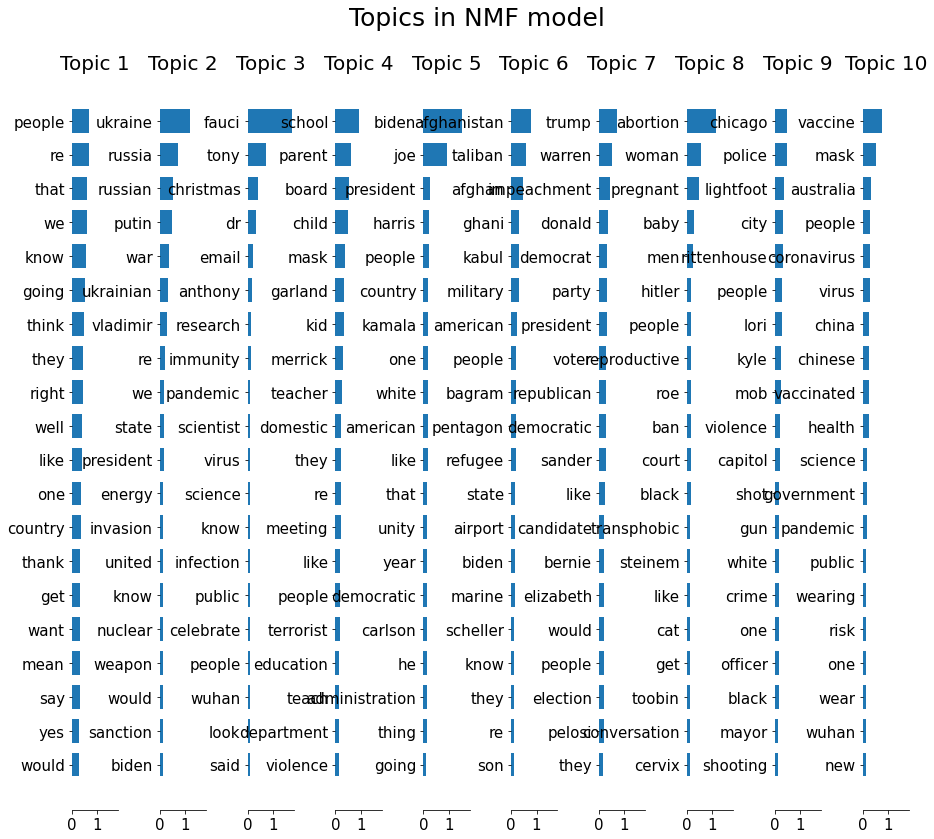

In [11]:
topic_word_plot()

In [12]:
#Manually re-assign topics
topic = {0: 'American Politics', 1: 'War in Ukraine', 2: 'Covid-19', 3: 'School', 4: 'Biden Administration', 
         5: 'War in Afghanistan', 6: 'Trump', 7: 'Abortion', 8: 'Kyle Rittenhouse Shooting', 
         9: 'Covid-19 Vaccine' }

## Preprocess the Twitter data

In [13]:
def twitter_preprocessing(text):

    #Step 0
    #This is Praveen's code
    text = text.lower()
    text = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+@[A-Z0-9_]+|#[A-Z0-9_]+|http\S+", "", text).strip().replace("\r", "").replace("\n", "").replace("\t", "")
   
    #step 1: delete all caps words
    t_d = re.sub(r'\b[A-Z]+\b', '', text)

    #step 2: tokenize
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenized_doc = nltk.regexp_tokenize(t_d, pattern)

    #step 3: stop words
    stopwords_list = stopwords.words('english')
    stop_tokenized_doc = [word for word in tokenized_doc if word not in stopwords_list]

    #step 4: lem
    tokens = [wnl.lemmatize(word) for word in stop_tokenized_doc]
    return ' '.join(tokens)

In [14]:
import ast

#Function library
def string_to_list(s):
    try:
        l = ast.literal_eval(s)
    except:
        l = None
    return l

def prepare_tweets(tweet_row):

    try:
        tweet_list = []
        for n in range(len(tweet_row)):
            tweet_list.append(twitter_preprocessing(tweet_row[n]))

        cleaned_tweets = []
        for tweet in tweet_list:
            if len(tweet) > 20:
                cleaned_tweets.append(tweet)
        return cleaned_tweets
    except:
        return None

In [15]:
#Turn pandas string-list view into literal list
tweet_df['tweet_history'] = tweet_df['tweet_history'].apply(lambda x: string_to_list(x))
tweet_df = tweet_df.dropna()
#Preprocess the tweets
tweet_df['cleaned_tweets'] = tweet_df['tweet_history'].apply(lambda x: prepare_tweets(x))

#Vectorize the tweets
tweet_df['vectorized'] = tweet_df['cleaned_tweets'].apply(lambda x: vectorizer.transform(x))

In [16]:
#Fit the NMF topic generation model

# to get H
H_list = []

for n in range(len(tweet_df)):
    try:
        H_list.append(model.transform(tweet_df['vectorized'][n])) # transform document into topic vector representation
    except:
        H_list.append(None)
        continue;

In [17]:
#List out the topic weights
topic_weights = []

for n in range(0, len(tweet_df)):
    topic_weights.append(list(pd.DataFrame(H_list[n], columns = list(topic.values())).mean()))

In [18]:
twitter_weights_df = pd.DataFrame(topic_weights,  columns = list(topic.values()))

In [19]:
#Generate tucker carlson distribution
tucker_weights_df = pd.DataFrame(model.transform(td_idf_df), columns = list(topic.values())).mean()

In [20]:
from scipy import spatial


spatial.distance.cosine(np.array(twitter_weights_df.iloc[0,:]), np.array(tucker_weights_df.iloc[:]))

0.14188729977387537

In [21]:
np.array(twitter_weights_df.iloc[0,:])

array([0.0071528 , 0.00257195, 0.00124804, 0.00769051, 0.00357502,
       0.00252398, 0.01042381, 0.00515307, 0.0026456 , 0.00234694])

In [22]:
np.array(tucker_weights_df.iloc[:])

array([0.05201031, 0.02124732, 0.01120795, 0.01697498, 0.02633728,
       0.01538183, 0.0321214 , 0.01245048, 0.02797214, 0.03113515])

In [23]:
full_twitter_df = twitter_weights_df.join(tweet_df[['tweet_history', 'cleaned_tweets']])
full_twitter_df = full_twitter_df.dropna()

In [24]:
cosine_list = []
for n in range(len(twitter_weights_df)):
    tweet_vec = np.array(twitter_weights_df.iloc[n,:])
    tuck_vec = np.array(tucker_weights_df.iloc[:])
    cosine_list.append(1 - spatial.distance.cosine(tweet_vec, tuck_vec))

In [25]:
cosine_series = pd.Series(cosine_list)

In [26]:
full_twitter_df['tucker_similarity'] = cosine_series

In [27]:
#full_twitter_df = full_twitter_df.sort_values(by = 'tucker_similarity', ascending=False).reset_index()
full_twitter_df.iloc[-10:-1]

,American Politics,War in Ukraine,Covid-19,School,Biden Administration,War in Afghanistan,Trump,Abortion,Kyle Rittenhouse Shooting,Covid-19 Vaccine,tweet_history,cleaned_tweets,tucker_similarity
3648,0.006079,0.001768,0.002354,0.006301,0.002168,0.003606,0.013000,0.005363,0.002969,0.009731,[RT @snark_land: Hey @MSNBC!\n\nMy wife commen...,[rt hey wife commented morning every time show...,0.847635
3649,0.004634,0.000593,0.001724,0.003052,0.003394,0.001186,0.009006,0.023598,0.002268,0.001467,[You forgot to add their messages are clearly ...,"[forgot add message clearly lie, hopefully peo...",0.495532
3650,0.003430,0.001944,0.000826,0.002517,0.000972,0.001781,0.008803,0.017931,0.003763,0.003157,"[""The 13 states with abortion-ban 'trigger law...",[state abortion ban trigger law completely unp...,0.565394
3651,0.004377,0.003747,0.003038,0.002150,0.004753,0.001494,0.003770,0.009559,0.003996,0.002863,[RT @heymiller: Twitter just asked me if I wan...,[rt twitter asked wanted read article retweeti...,0.789574
3652,0.005525,0.000625,0.000616,0.003939,0.001605,0.000991,0.003495,0.017816,0.001839,0.001445,[I wanted to mention something Weddington addr...,[wanted mention something weddington addressed...,0.509294
3653,0.011674,0.002683,0.001670,0.004588,0.002773,0.002827,0.003433,0.008241,0.003290,0.002239,[@TheView I was watching PBS news and they wer...,[watching pb news special roe v wade original ...,0.869700
3654,0.007080,0.014011,0.001937,0.001068,0.003186,0.000855,0.004257,0.007433,0.004999,0.001650,[Putin's War on his independent brothers&amp;s...,[putin's war independent brother amp sister co...,0.744128
3655,0.007877,0.000607,0.000663,0.002663,0.001066,0.001662,0.002618,0.006367,0.002338,0.002096,"[If anyone wants to try it for themselves, her...",[anyone want try recipe thing beyond recipe ad...,0.833226
3656,0.003500,0.005957,0.002945,0.003565,0.003756,0.003787,0.006055,0.011467,0.003212,0.004341,[China‘s Uncontested Candidate ‘Wins‘ Hong Kon...,[china uncontested candidate win hong kong chi...,0.757249


In [28]:
#Manually labeled predictions
itemized_cats_like_tucker = [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 
                             1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

itemized_cats_dislike_tucker = [0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
                                0, 0, 1, 1, 0, 0, 0, 0, 0, 1]

#True values (Top 20 like tucker, top 20 unlike tucker)
itemized_cats_like_tucker_true = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

itemized_cats_dislike_tucker_false = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

tucker_pred = np.array(itemized_cats_like_tucker + itemized_cats_dislike_tucker)
tucker_true = np.array(itemized_cats_like_tucker_true + itemized_cats_dislike_tucker_false)

#full_twitter_df['tweet_history'][3636]



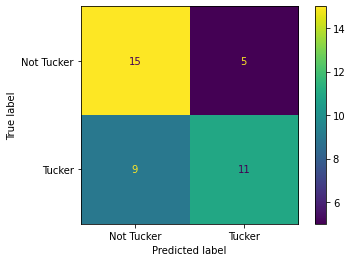

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

conf_mat = confusion_matrix(tucker_true, tucker_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Not Tucker', 'Tucker'])
disp.plot();

In [30]:
print(classification_report(tucker_true, tucker_pred))

              precision    recall  f1-score   support

           0       0.62      0.75      0.68        20
           1       0.69      0.55      0.61        20

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.65        40
weighted avg       0.66      0.65      0.65        40

